# <font style = "color:rgb(50,120,229)">SnapChat Filters : Beardify</font>

# <font style = "color:rgb(50,120,229)">Beard Filter</font>

In this chapter, we will learn how to apply beard on a face. The main concepts involved are Warping of triangles, Delaunay Triangulation and Alpha Blending.

| <center> <a href="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m3-srcface.jpg"><img src = "https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m3-srcface.jpg" width=400/></a></center> | <center> <a href="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m3-bearedFace.jpg"><img src = "https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m3-bearedFace.jpg" width=400/></a></center> |
| -------- | -------- |


## <font style = "color:rgb(50,120,229)">The Core Idea</font>

In the previous section (face swap) we discussed how to extract a person’s face from one image and apply it on another person’s image. We will use a similar approach here.

To apply a beard on a face, we will use beard from source image and apply it on jawline + lips boundary portions of face on destination image. In order to do this, we will need points marked on lips boundary and jawline which define an outline of beard and moustache. There are 2 ways we can get source image of beard:

1. Image of only beard with corresponding dlib points marked manually on the beard.

2. Image of a bearded person

In this case we will use dlib’s facial landmark detector on the face image to get the coordinates of relevant points. But getting an image of a person with beard with alpha mask is very rare.

In this tutorial, we will use first option to apply beard.

Why? Because the image of beard we have, is a png image with transparency mask. We can use this mask for efficiently blending the beard on any given face.

We will use following points (out of 68 landmark points) marked on image to apply beard from source image to destination image.

<center> <a href="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m3-beraedMask.jpg"><img src = "https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m3-beraedMask.jpg" width=400/></a></center>

&nbsp;
We will use these points and affine warp it on the target image using delaunay triangulation. Just like face swap we will also use alpha blending to make blending look smooth. The difference here is that we will use transparency mask of beard and not the mask provided by the convex hull as in the case of faceswap.

You can use this method to overlay any other object like flowerband, spectacles etc, as discussed in the previous chapter.

## <font style = "color:rgb(50,120,229)">Code and Tutorial for Beardify</font>

We have provided code for both the image and video versions. We will explain the video version here. The same explanations go for the image version also. 

Now let’s dive into the code and find out the implementation of the ideas we discussed.

In [1]:
#include "includeLibraries.h"
#include "matplotlibcpp.h"
#include "displayImages.h"

In [2]:
#include <opencv2/opencv.hpp>
#include <opencv2/highgui/highgui.hpp>
#include <dlib/image_processing/frontal_face_detector.h>
#include <dlib/image_processing.h>
#include <dlib/image_io.h>
#include <dlib/gui_widgets.h>
#include <opencv2/imgproc.hpp> // If you are using OpenCV 3
#include <iostream>
#include <fstream>
#include <string>
#include <dlib/opencv.h>
#include <stdlib.h>
#include "faceBlendCommon.hpp"

In [3]:
using namespace cv;

In [4]:
using namespace std;

In [5]:
using namespace dlib;

Specify the resize options for working image and image used for Dlib face detector.

In [6]:
#define FACE_DOWNSAMPLE_RATIO 1

Since beard points are a subset of the 68 points, we have to select the points from dlib which we have marked on the beard.

<img src="https://www.learnopencv.com/wp-content/uploads/2019/10/ted-beardify-annotation.jpg" width = 1000 />

In [7]:
int selectedpoints[] = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 31, 32, 33, 34, 35, 55, 56, 57, 58, 59};
std::vector<int> selectedIndex (selectedpoints, selectedpoints + sizeof(selectedpoints) / sizeof(int) );

Function to read the contents of the file and convert them into a list called points. This will be used for getting the points corresponding to dlib points for the beard.


In [8]:
// Read points corresponding to beard, stored in text files
std::vector<Point2f> getSavedPoints(string pointsFileName)
{
  std::vector<Point2f> points;
  ifstream ifs(pointsFileName.c_str());
  float x, y;
  if (!ifs)
    cout << "Unable to open file" << endl;
  while(ifs >> x >> y)
  {
    points.push_back(Point2f(x,y));
  }
  return points;
}

Specifying the variables for dlib face landmark detector and input image for swapping the face in the video. 

In [9]:
// Load face detection and pose estimation models.
string modelPath = DATA_PATH + "models/shape_predictor_68_face_landmarks.dat";
frontal_face_detector detector = get_frontal_face_detector();
shape_predictor predictor;
deserialize(modelPath) >> predictor;

Load the transparent png image with the alpha mask. This is done using the `cv::IMREAD_UNCHANGED` flag. It loads the image with 4 channels. We use the first three channels for the beard and the fourth channel as the mask for the beard.

In [10]:
string overlayFile = DATA_PATH + "images/beard1.png";
string imageFile = DATA_PATH + "images/ted_cruz.jpg";

In [11]:
// Read the beard image along with its alpha mask
Mat beard, targetImage, beardAlphaMask;
Mat imgWithMask = imread(overlayFile,IMREAD_UNCHANGED);
std::vector<Mat> rgbaChannels(4);

// Split into channels
split(imgWithMask, rgbaChannels);

// Extract the beard image
std::vector<Mat> bgrchannels;
bgrchannels.push_back(rgbaChannels[0]);
bgrchannels.push_back(rgbaChannels[1]);
bgrchannels.push_back(rgbaChannels[2]);

merge(bgrchannels, beard);
beard.convertTo(beard, CV_32F, 1.0/255.0);

// Extract the beard mask
std::vector<Mat> maskchannels;
maskchannels.push_back(rgbaChannels[3]);
maskchannels.push_back(rgbaChannels[3]);
maskchannels.push_back(rgbaChannels[3]);

merge(maskchannels, beardAlphaMask);
beardAlphaMask.convertTo(beardAlphaMask, CV_32FC3);

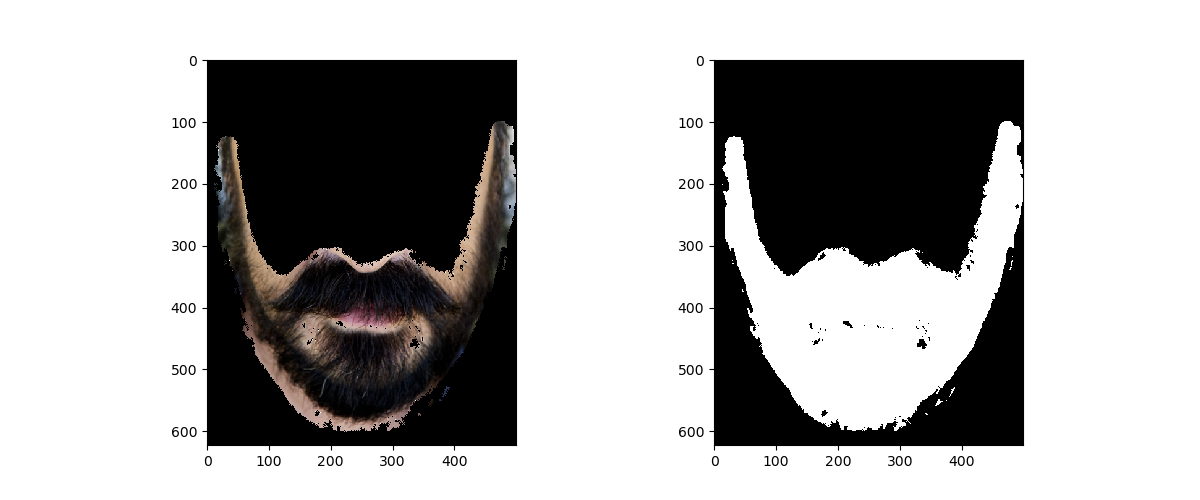

In [12]:
plt::figure_size(1200,500);
plt::subplot(1,2,1);
plt::imshow(beard);
auto pltImg = displayImage(beard);
plt::subplot(1,2,2);
plt::imshow(beardAlphaMask);
pltImg = displayImage(beardAlphaMask);

pltImg

Read the points on the beard which correspond to the dlib points using the function defined above. Find delaunay triangles using these points to perform warping later.

In [13]:
//Read points for beard from file
std::vector<Point2f> featurePoints1 = getSavedPoints( overlayFile + ".txt");

// Calculate Delaunay triangles
Rect rect = boundingRect(featurePoints1);

std::vector< std::vector<int> > dt;
calculateDelaunayTriangles(rect, featurePoints1, dt);

In [14]:
float time_detector = (double)cv::getTickCount();
// Get the face image for putting the beard
targetImage = imread(imageFile);
// int height = targetImage.rows;
// float IMAGE_RESIZE = (float)height/RESIZE_HEIGHT;
// cv::resize(targetImage, targetImage, cv::Size(), 1.0/IMAGE_RESIZE, 1.0/IMAGE_RESIZE);

std::vector<Point2f> points2 = getSavedPoints(imageFile + ".txt");
// std::vector<Point2f> points2 = getLandmarks(detector, predictor, targetImage, (float)FACE_DOWNSAMPLE_RATIO);

std::vector<Point2f> featurePoints2;
for( int i = 0; i < selectedIndex.size(); i++)
{
featurePoints2.push_back(points2[selectedIndex[i]]);
constrainPoint(featurePoints2[i], targetImage.size());
}
//convert Mat to float data type
targetImage.convertTo(targetImage, CV_32F, 1.0/255.0);

//empty warp image
Mat beardWarped = Mat::zeros(targetImage.size(), beard.type());
Mat beardAlphaMaskWarped = Mat::zeros(targetImage.size(), beardAlphaMask.type());

// Apply affine transformation to Delaunay triangles
for(size_t i = 0; i < dt.size(); i++)
{
std::vector<Point2f> t1, t2;
// Get points for img1, targetImage corresponding to the triangles
for(size_t j = 0; j < 3; j++)
{
  t1.push_back(featurePoints1[dt[i][j]]);
  t2.push_back(featurePoints2[dt[i][j]]);
}
warpTriangle(beard, beardWarped, t1, t2);
warpTriangle(beardAlphaMask, beardAlphaMaskWarped, t1, t2);
}

In [15]:
Mat mask1;
beardAlphaMaskWarped.convertTo(mask1, CV_32FC3, 1.0/255.0);

Mat mask2 = Scalar(1.0,1.0,1.0) - mask1;
Mat temp1 = targetImage.mul(mask2);
Mat temp2 = beardWarped.mul(mask1);

Mat result = temp1 + temp2;

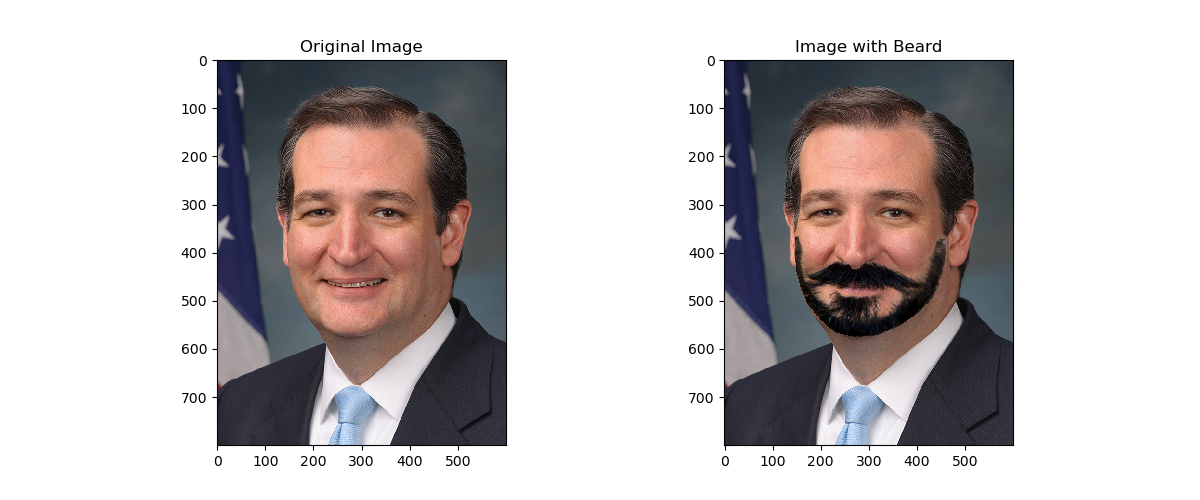

In [16]:
plt::figure_size(1200,500);
plt::subplot(1,2,1);
plt::imshow(targetImage);
plt::title("Original Image");
pltImg = displayImage(targetImage);

plt::subplot(1,2,2);
plt::imshow(result);
plt::title("Image with Beard");
pltImg = displayImage(result);

pltImg